<a href="https://colab.research.google.com/github/haedongmu/AIFFEL_quest_cr/blob/main/Project/Main_Quest04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#구글드라이브 마운트하기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_file_path = '/content/drive/My Drive/아이펠/archive.zip'


# 2. 압축 파일 경로 설정
extract_to_path = '/content/drive/My Drive/아이펠/archive'


# 3. 압축 해제
import zipfile
import os

os.makedirs(extract_to_path, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Dataset extracted to: {extract_to_path}")

Dataset extracted to: /content/drive/My Drive/아이펠/archive


In [ ]:
!find "/content/drive/My Drive/아이펠/archive/chest_xray" -name '.DS_Store' -delete

/content/drive/My Drive/아이펠/archive
5216
624
16
4185
1047
Normal image path
/content/drive/My Drive/아이펠/archive/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0707-0001.jpeg
Pneumonia image path
/content/drive/My Drive/아이펠/archive/chest_xray/chest_xray/train/PNEUMONIA/person610_bacteria_2475.jpeg
Normal images count in training set: 1070
Pneumonia images count in training set: 3115
Training images count: 4185
Validating images count: 1047
Image shape:  (180, 180, 3)
Label:  0
624
Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67
Virtual devices cannot be modified after being initialized
Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 126s 376ms/step - accuracy: 0.7357 - loss: 0.4834 - precision: 0.9239 - recall: 0.7010 - val_accuracy: 0.7337 - val_loss: 0.6300 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 76s 292ms/step - accuracy: 0.9014 - loss: 0.2326 - precision: 0.9692 - recall: 0.8973 - val_accuracy: 0.7346 - val_loss: 1.3303 - val_precision: 0.7346 

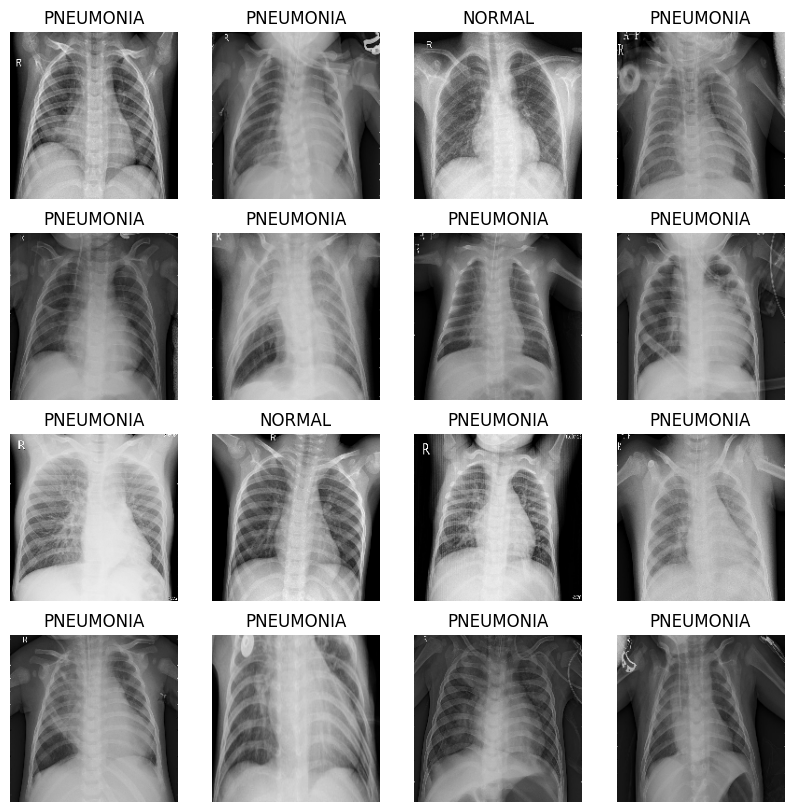

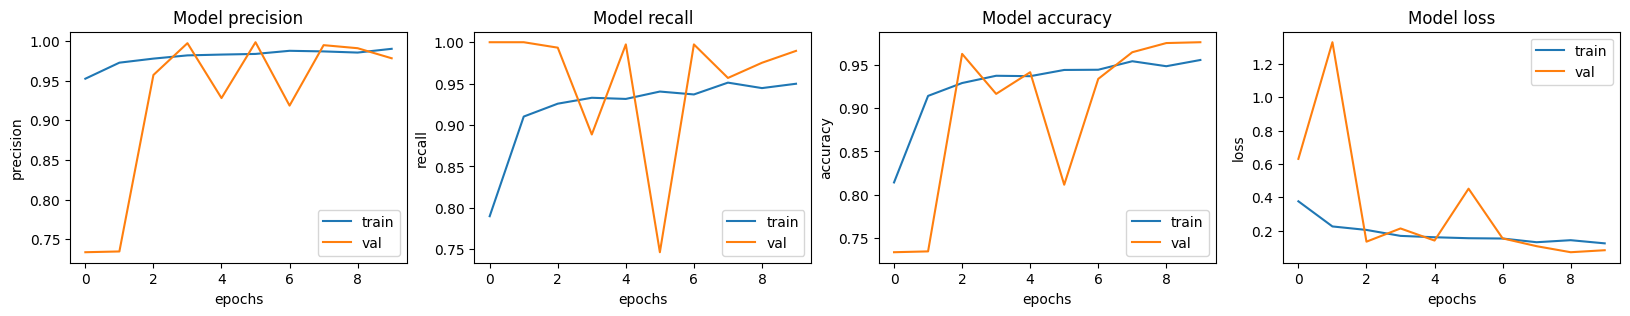

In [ ]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = '/content/drive/My Drive/아이펠/archive'
TRAIN_PATH = ROOT_PATH + '/chest_xray/chest_xray/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/chest_xray/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")


# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    label = tf.cast(label, tf.int32)  # bool -> int32 변환**
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model


weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))


with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)]  # 10GB 제한
        )
    except RuntimeError as e:
        print(e)


with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [ ]:
import tensorflow as tf

def residual_block(x, filters, stride=1):
    shortcut = x  # Identity connection

    # 첫 번째 Conv
    x = tf.keras.layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # 두 번째 Conv
    x = tf.keras.layers.Conv2D(filters, 3, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Shortcut 연결 (차원이 다르면 Conv로 맞춤)
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    # Residual 연결
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)

    return x


In [ ]:
def build_resnet18(input_shape=(224, 224, 3), num_classes=1000):
    inputs = tf.keras.Input(shape=input_shape)

    # Conv1
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Conv2_x
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    # Conv3_x
    x = residual_block(x, filters=128, stride=2)  # 첫 Residual Block에서 다운샘플링
    x = residual_block(x, filters=128)

    # Conv4_x
    x = residual_block(x, filters=256, stride=2)  # 첫 Residual Block에서 다운샘플링
    x = residual_block(x, filters=256)

    # Conv5_x
    x = residual_block(x, filters=512, stride=2)  # 첫 Residual Block에서 다운샘플링
    x = residual_block(x, filters=512)

    # Average Pooling & Fully Connected
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
resnet18 = build_resnet18(input_shape=(224, 224, 3), num_classes=1000)
resnet18.summary()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 112, 112, 64)   │          9,472 │ input_layer_40[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_35    │ (None, 112, 112, 64)   │            256 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 112, 112, 64)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_25          │ (None, 56, 56, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 56, 56, 64)     │            256 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 56, 56, 64)     │            256 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 64)     │              0 │ batch_normalization_3… │
│                           │                        │                │ max_pooling2d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 56, 56, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 56, 56, 64)     │            256 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ re_lu_3[0][0]          │
├──────────────────────

 Total params: 11,703,912 (44.65 MB)

 Trainable params: 11,694,312 (44.61 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [ ]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

# 데이터 로드 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]  # 이미지 사이즈
BATCH_SIZE = 16
EPOCHS = 10

# 데이터 경로
ROOT_PATH = '/content/drive/My Drive/아이펠/archive'
TRAIN_PATH = ROOT_PATH + '/chest_xray/chest_xray/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/chest_xray/test/*/*'

# 데이터 파일 로드
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# Train과 Validation 데이터를 결합 후 8:2로 나눔
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames) * 0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# 데이터 전처리 함수
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return tf.cast(parts[-2] == "PNEUMONIA", tf.int32)

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Residual Block 정의
def residual_block(x, filters, stride=1):
    shortcut = x
    x = tf.keras.layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(filters, 3, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x

# ResNet-18 모델 정의
def build_resnet18(input_shape=(180, 180, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128)

    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256)

    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# 클래스 가중치 계산
weight_for_0 = (1 / COUNT_NORMAL) * (len(train_filenames)) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (len(train_filenames)) / 2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

# 모델 생성 및 컴파일
with tf.device('/GPU:0'):
    model = build_resnet18()
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )

# 모델 훈련
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=len(train_filenames) // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=len(val_filenames) // BATCH_SIZE,
        class_weight=class_weight
    )

# 결과 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
metrics = ['loss', 'accuracy', 'precision', 'recall']
for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric], label='train')
    ax[i].plot(history.history[f'val_{metric}'], label='val')
    ax[i].set_title(metric)
    ax[i].legend()

# 테스트 데이터 평가
test_ds = tf.data.Dataset.list_files(TEST_PATH).map(process_path).batch(BATCH_SIZE)
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')


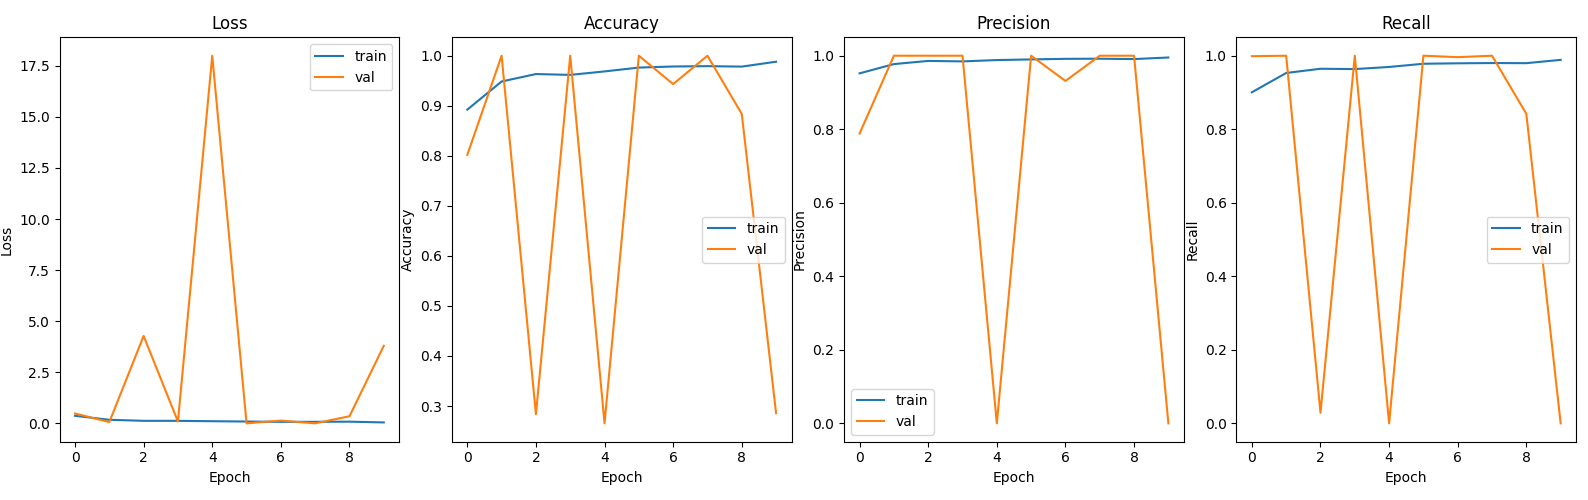

Train data 개수: 4185
Val data 개수: 1047
Test data 개수: 624
Train - NORMAL: 1072 / PNEUMONIA: 3113
Class weight: {0: 1.9519589552238805, 1: 1.008271763572117}
2025-01-14 23:46:08.627587: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.8315 - loss: 0.5943 - precision: 0.9196 - recall: 0.8421 - val_accuracy: 0.8019 - val_loss: 0.4836 - val_precision: 0.7882 - val_recall: 0.9987
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9529 - loss: 0.1565 - precision: 0.9802 - recall: 0.95682025-01-14 23:47:30.730059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
261/261 ━━━━━━━━━━━━━━━━━━━━ 36s 139ms/step - accuracy: 0.9528 - loss: 0.1565 - precision: 0.9802 - recall: 0.9568 - val_accuracy: 1.0000 - val_loss: 0.0629 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 40s 153ms/step - accuracy: 0.9611 - loss: 0.1342 - precision: 0.9841 - recall: 0.9634 - val_accuracy: 0.2837 - val_loss: 4.2764 - val_precision: 1.0000 - val_recall: 0.0287
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 36s 139ms/step - accuracy: 0.9652 - loss: 0.1086 - precision: 0.9862 - recall: 0.9672 - val_accuracy: 1.0000 - val_loss: 0.0914 - val_precision: 1.0000 - val_recall: 1.0000
2025-01-14 23:48:47.019569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.9690 - loss: 0.1008 - precision: 0.9877 - recall: 0.9706 - val_accuracy: 0.2654 - val_loss: 17.9900 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 37s 141ms/step - accuracy: 0.9740 - loss: 0.0814 - precision: 0.9912 - recall: 0.9737 - val_accuracy: 1.0000 - val_loss: 0.0015 - val_precision: 1.0000 - val_recall: 1.0000
2025-01-14 23:50:04.652633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - accuracy: 0.9776 - loss: 0.0782 - precision: 0.9896 - recall: 0.9797 - val_accuracy: 0.9433 - val_loss: 0.1359 - val_precision: 0.9314 - val_recall: 0.9961
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 36s 140ms/step - accuracy: 0.9791 - loss: 0.0804 - precision: 0.9916 - recall: 0.9803 - val_accuracy: 1.0000 - val_loss: 0.0016 - val_precision: 1.0000 - val_recall: 1.0000
2025-01-14 23:51:21.635442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
Epoch 9/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.9786 - loss: 0.0852 - precision: 0.9904 - recall: 0.9807 - val_accuracy: 0.8837 - val_loss: 0.3490 - val_precision: 1.0000 - val_recall: 0.8418
Epoch 10/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 36s 139ms/step - accuracy: 0.9874 - loss: 0.0475 - precision: 0.9944 - recall: 0.9887 - val_accuracy: 0.2857 - val_loss: 3.7935 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
2025-01-14 23:52:38.479623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]

[Evaluation on Test Set]
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7831 - loss: 0.8166 - precision: 0.5492 - recall: 0.1638
Loss: 1.7819, Accuracy: 0.5288, Precision: 0.9528, Recall: 0.2590
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

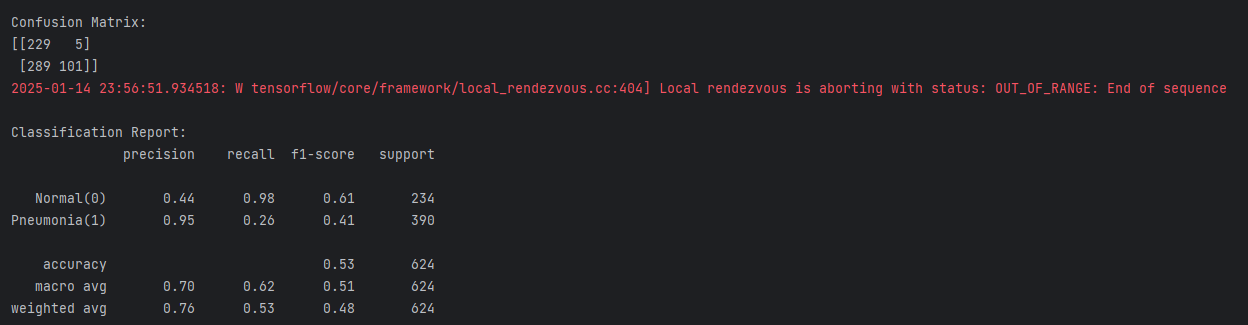